In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv("./clean_data.csv", index_col=['TimeIndex'])

In [22]:
room = '556'
df = data[data['room'] == room].iloc[:50000][['co2', 'light', 'humidity', 'temperature']]

In [23]:
# делим на train/test
train_split = 0.9
train_split_n = int(len(df) * train_split)

train       = df.iloc[:train_split_n]
test        = df.iloc[train_split_n:]

In [24]:
train

,co2,light,humidity,temperature
TimeIndex,,,,
2013-08-23 23:13:25,589.0,43.0,49.06,24.29
2013-08-23 23:13:30,600.0,43.0,49.10,24.30
2013-08-23 23:13:35,589.0,41.0,49.06,24.30
2013-08-23 23:13:40,587.0,43.0,49.06,24.30
2013-08-23 23:13:45,587.0,42.0,49.10,24.30
...,...,...,...,...
2013-08-26 13:43:00,435.0,4.0,55.83,23.80
2013-08-26 13:43:05,432.0,4.0,55.83,23.78
2013-08-26 13:43:10,434.0,3.0,55.83,23.80


In [17]:
from statsmodels.tsa.stattools import adfuller

# Стационарность
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [25]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.607
 No. Lags Chosen       = 53
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "light" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6497
 No. Lags Chosen       = 18
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [29]:
# 1st difference
df_differenced = train.diff().dropna()

for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -42.5113
 No. Lags Chosen       = 56
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "light" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -52.4254
 No. Lags Chosen       = 17
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

Все ряды стационарны

In [30]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(df)
x = model.select_order(maxlags=100)
x.summary()

c:\ProgramData\miniconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5s will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,11.01,11.01,6.071e+04,11.01
1,-14.04,-14.04,7.964e-07,-14.04
2,-14.72,-14.71,4.067e-07,-14.71
3,-14.90,-14.89,3.396e-07,-14.89
4,-14.97,-14.95,3.168e-07,-14.96
5,-15.01,-14.99,3.033e-07,-15.00
6,-15.05,-15.03,2.915e-07,-15.04
7,-15.07,-15.05,2.848e-07,-15.07
8,-15.09,-15.07,2.793e-07,-15.08
9,-15.10,-15.08,2.763e-07,-15.09


Выбираем лаг 38

In [86]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
    
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Appliances : 2.0
T9 : 2.0
Visibility : 2.0
Tdewpoint : 2.0


In [90]:
forecast_input = df.values[-lags:]
forecast_input

array([[ 60.        ,  22.7       ,  62.        ,  10.9       ],
       [ 40.        ,  22.7       ,  62.        ,  10.9       ],
       [ 60.        ,  22.7       ,  61.83333333,  10.9       ],
       [ 40.        ,  22.7       ,  61.66666667,  10.9       ],
       [ 60.        ,  22.7       ,  61.5       ,  10.9       ],
       [ 50.        ,  22.7       ,  61.33333333,  11.        ],
       [ 50.        ,  22.7       ,  61.16666667,  11.        ],
       [ 60.        ,  22.7       ,  61.        ,  11.        ],
       [ 60.        ,  22.7       ,  59.66666667,  11.1       ],
       [ 60.        ,  22.7       ,  58.33333333,  11.1       ],
       [ 60.        ,  22.7       ,  57.        ,  11.2       ],
       [ 50.        ,  22.7       ,  55.66666667,  11.3       ],
       [ 60.        ,  22.7       ,  54.33333333,  11.3       ],
       [ 60.        ,  22.7       ,  53.        ,  11.4       ],
       [ 60.        ,  22.7       ,  51.66666667,  11.4       ],
       [ 60.        ,  22

In [91]:
# Forecast
nobs = 100 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Appliances_2d,T9_2d,Visibility_2d,Tdewpoint_2d
date,,,,
27-05-2016 01:30,324.282147,23.202007,26.748436,13.190124
27-05-2016 01:40,258.912007,23.203331,26.703232,13.206190
27-05-2016 01:50,233.979003,23.207448,27.052768,13.226238
27-05-2016 02:00,212.923331,23.207302,27.584325,13.246171
27-05-2016 02:10,211.110627,23.197906,28.342341,13.262565
...,...,...,...,...
27-05-2016 17:20,98.114946,23.439034,35.973777,11.684274
27-05-2016 17:30,98.657687,23.445889,35.961519,11.676811
27-05-2016 17:40,101.033249,23.451032,35.954676,11.665142


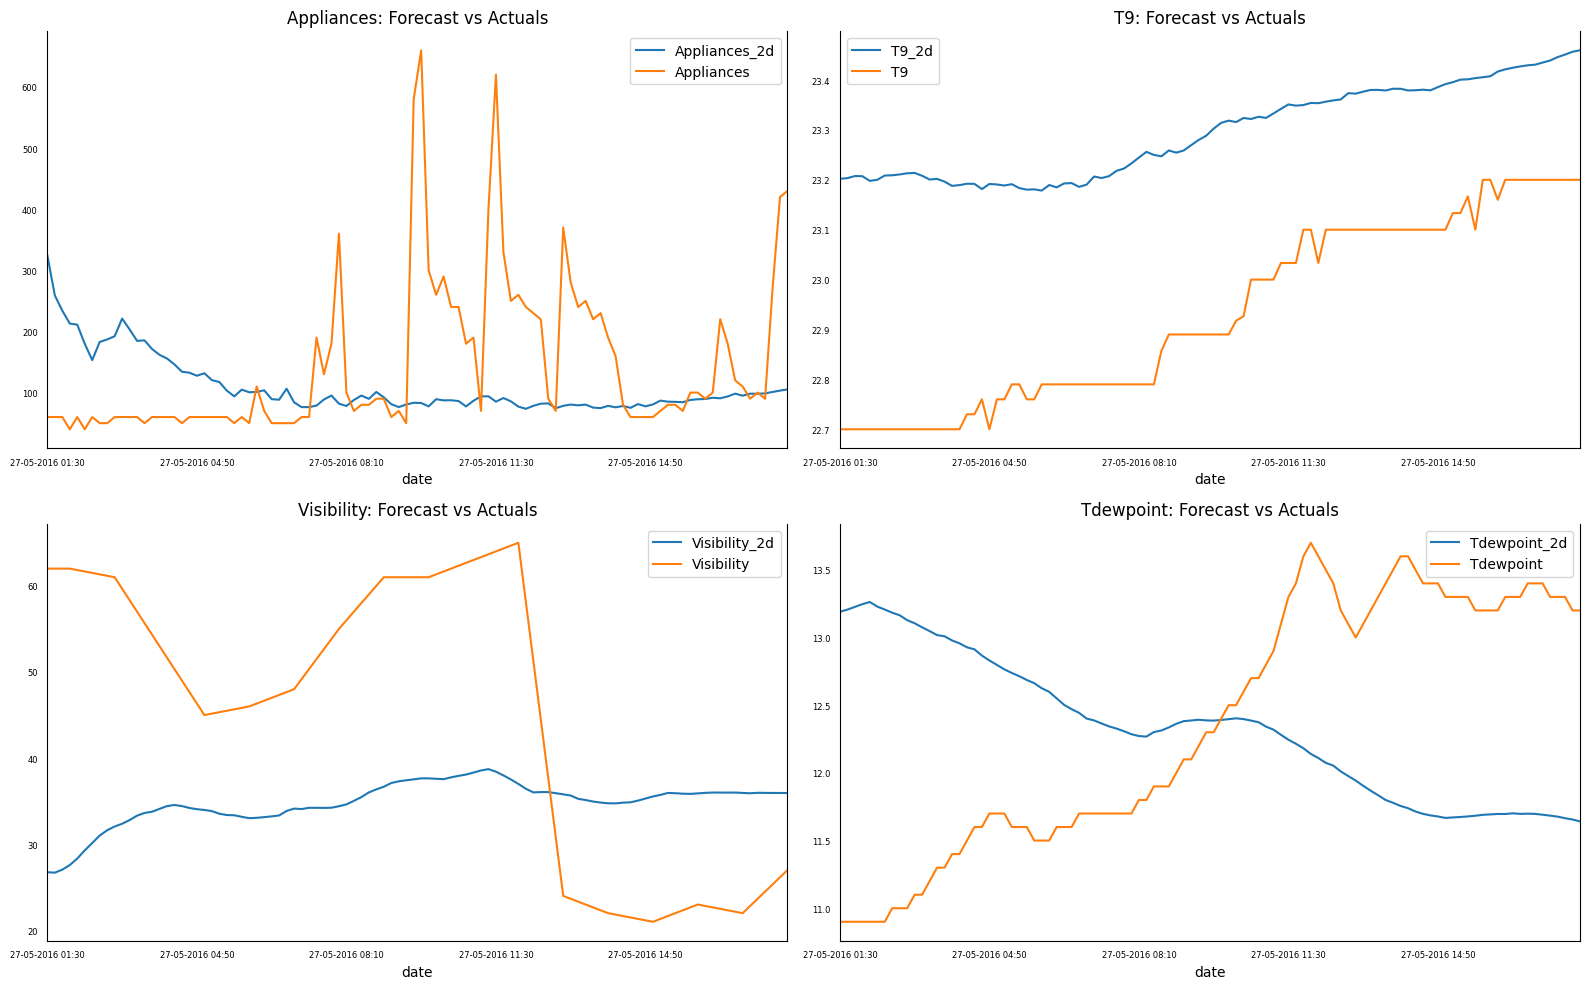

In [93]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(16,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+"_2d"].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();